In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import time
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, MobileNetV2
from tensorflow.keras.optimizers import Adam
import subprocess

In [ ]:
# Step 1: Load Dataset from Kaggle Hub
import kagglehub

# Download the dataset
data_dir = kagglehub.dataset_download("gpiosenka/tree-nuts-image-classification")

# Dataset paths
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')
csv_path = os.path.join(data_dir, 'tree nuts.csv')

In [ ]:
# Step 2: Load Class Information from CSV
csv_data = pd.read_csv(csv_path)
class_mapping = {label: index for index, label in enumerate(csv_data['labels'].unique())}

In [ ]:
# Function to map filepaths to labels
def map_filepaths_to_labels(base_dir, csv_data, class_mapping):
    filepaths, labels = [], []
    for _, row in csv_data.iterrows():
        class_name = row['labels']
        class_dir = os.path.join(base_dir, class_name)
        if os.path.exists(class_dir):
            for filename in os.listdir(class_dir):
                filepaths.append(os.path.join(class_dir, filename))
                labels.append(class_mapping[class_name])
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

train_data = map_filepaths_to_labels(train_dir, csv_data, class_mapping)
valid_data = map_filepaths_to_labels(valid_dir, csv_data, class_mapping)
test_data = map_filepaths_to_labels(test_dir, csv_data, class_mapping)

In [ ]:
# Convert classes to numpy array for compute_class_weight
classes_array = np.array(list(class_mapping.values()))

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=classes_array, y=train_data['labels'].values)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# Step 3: Preprocessing and Dataset Creation

def preprocess_image(filepath, label, img_size=(75, 75)):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255.0  # Normalize
    return img, label

def create_dataset(dataframe, img_size=(75, 75), batch_size=8, augment=False):
    filepaths = dataframe['filepaths'].values
    labels = dataframe['labels'].values

    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(lambda x, y: preprocess_image(x, y, img_size), num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(lambda x, y: (tf.image.random_flip_left_right(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.shuffle(len(dataframe)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_data, augment=True)
valid_dataset = create_dataset(valid_data)
test_dataset = create_dataset(test_data)

In [ ]:
# Step 4: Build Models

def build_cnn_model(input_shape=(75, 75, 3), num_classes=len(class_mapping)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

def build_transfer_learning_model(base_model, num_classes=len(class_mapping)):
    base_model.trainable = False  # Freeze base model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

base_models = {
    "CNN": build_cnn_model(),
    "VGGNet": VGG16(weights='imagenet', include_top=False, input_shape=(75, 75, 3)),
    "InceptionNet": InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3)),
    "ResNet": ResNet50(weights='imagenet', include_top=False, input_shape=(75, 75, 3)),
    "MobileNet": MobileNetV2(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
}

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-31-c6b0a5b2a4e4>:32: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  "MobileNet": MobileNetV2(weights='imagenet', include_top=False, input_shape=(75, 75, 3))


Training CNN...
Memory usage (MB): [2599]
Epoch 1/5
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 0.5032 - loss: 1.4193 - val_accuracy: 0.3439 - val_loss: 2.8380
Epoch 2/5
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - accuracy: 0.9656 - loss: 0.1032 - val_accuracy: 0.4307 - val_loss: 3.4602
Epoch 1/2
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 0.9723 - loss: 0.0874 - val_accuracy: 0.3653 - val_loss: 3.2621
Epoch 2/2
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - accuracy: 0.9807 - loss: 0.0603 - val_accuracy: 0.3368 - val_loss: 3.5700
790/790 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2549 - loss: 3.8980
790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Confusion Matrix:
[[111  35 104  22  55  32  95  63  31  47]
 [155  51 117  24  62  33 129  91  38  40]
 [137  37 112  35  80  34 126  89  33  47]
 [104  27  79  20  56  23  75  63  31  42]
 [138  50 101  21  68  26 101  77  27  41]
 [103  30  82  20  60  26  92  56  38  48]
 [169  41 133  21  90  34 155 120  41 

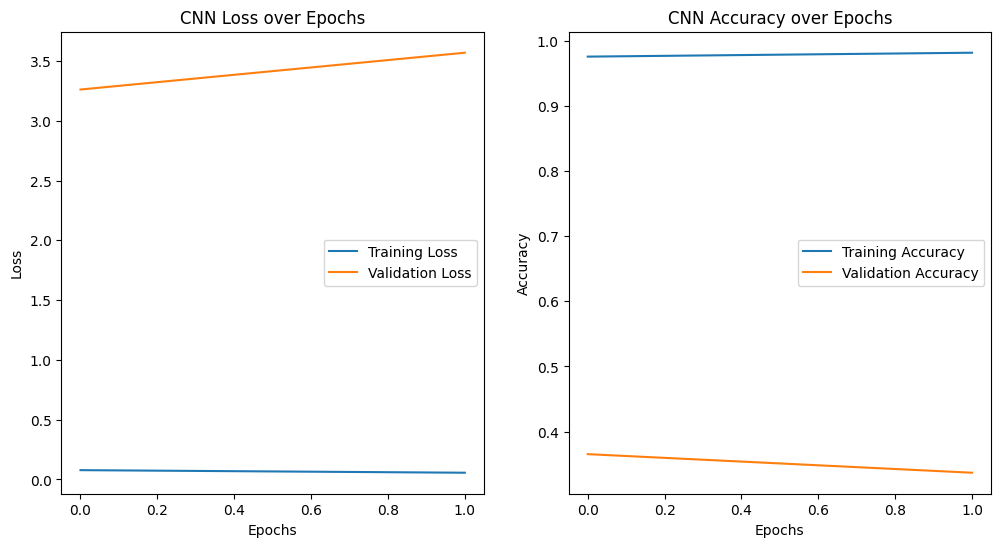

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Training VGGNet...
Memory usage (MB): [2601]
Epoch 1/5
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - accuracy: 0.6409 - loss: 1.1133 - val_accuracy: 0.6057 - val_loss: 1.6152
Epoch 2/5
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.9913 - loss: 0.0609 - val_accuracy: 0.5696 - val_loss: 2.4284
Epoch 1/2
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 155s 7ms/step - accuracy: 0.9787 - loss: 0.0692 - val_accuracy: 0.7086 - val_loss: 1.3792
Epoch 2/2
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 144s 7ms/step - accuracy: 0.9940 - loss: 0.0179 - val_accuracy: 0.7444 - val_loss: 1.5070
790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accu

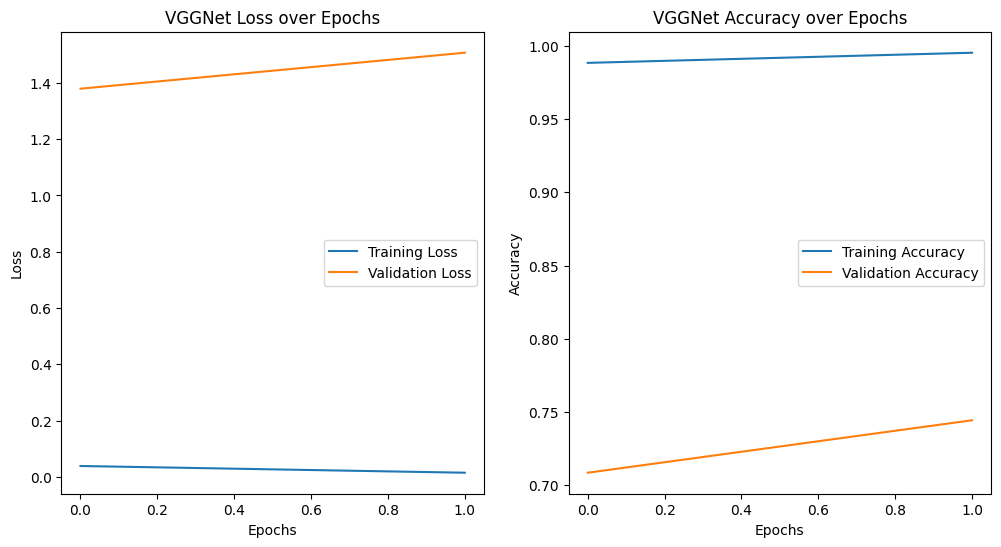

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training InceptionNet...
Memory usage (MB): [2603]
Epoch 1/5
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 175s 8ms/step - accuracy: 0.7354 - loss: 0.8550 - val_accuracy: 0.5154 - val_loss: 2.0803
Epoch 2/5
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 154s 7ms/step - accuracy: 0.9961 - loss: 0.0208 - val_accuracy: 0.5146 - val_loss: 2.7060
Epoch 1/2
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 489s 22ms/step - accuracy: 0.3165 - loss: 2.2668 - val_accuracy: 0.4825 - val_loss: 5.3437
Epoch 2/2
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 406s 21ms/step - accuracy: 0.7098 - loss: 0.8373 - val_accuracy: 0.5300 - val_loss: 15.3776
790/790 ━━━━━━━━━━━━━━━━━━━━ 6s 7

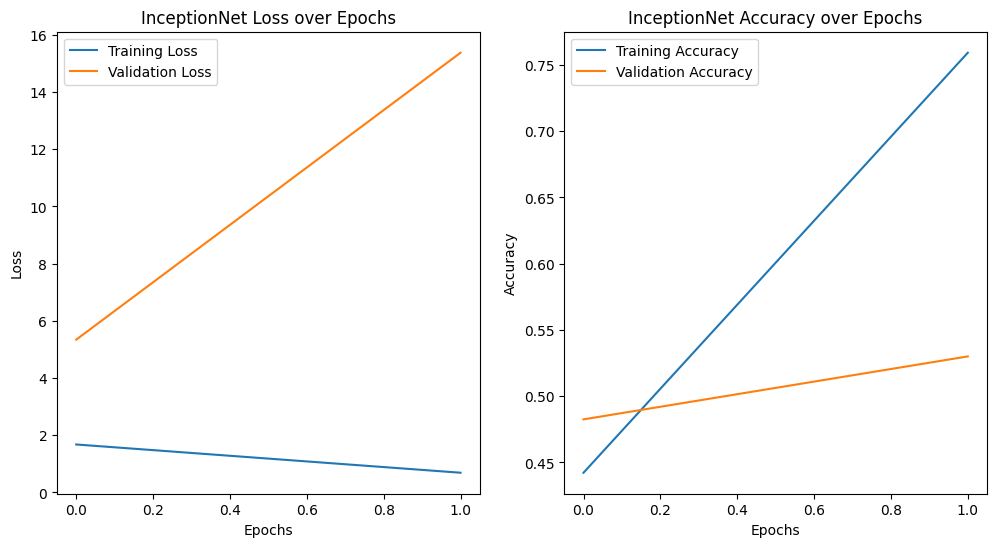

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Training ResNet...
Memory usage (MB): [4657]
Epoch 1/5
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 156s 7ms/step - accuracy: 0.2015 - loss: 2.1285 - val_accuracy: 0.3218 - val_loss: 1.7648
Epoch 2/5
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 138s 7ms/step - accuracy: 0.3646 - loss: 1.7496 - val_accuracy: 0.3625 - val_loss: 1.6901
Epoch 3/5
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 138s 7ms/step - accuracy: 0.4567 - loss: 1.4883 - val_accuracy: 0.4119 - val_loss: 1.7086
Epoch 1/2
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 440s 20ms/step - accuracy: 0.6397 - loss: 2.0983 - val_accuracy: 0.7577 - val_loss: 1.1416
Epoch 2/2
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 3

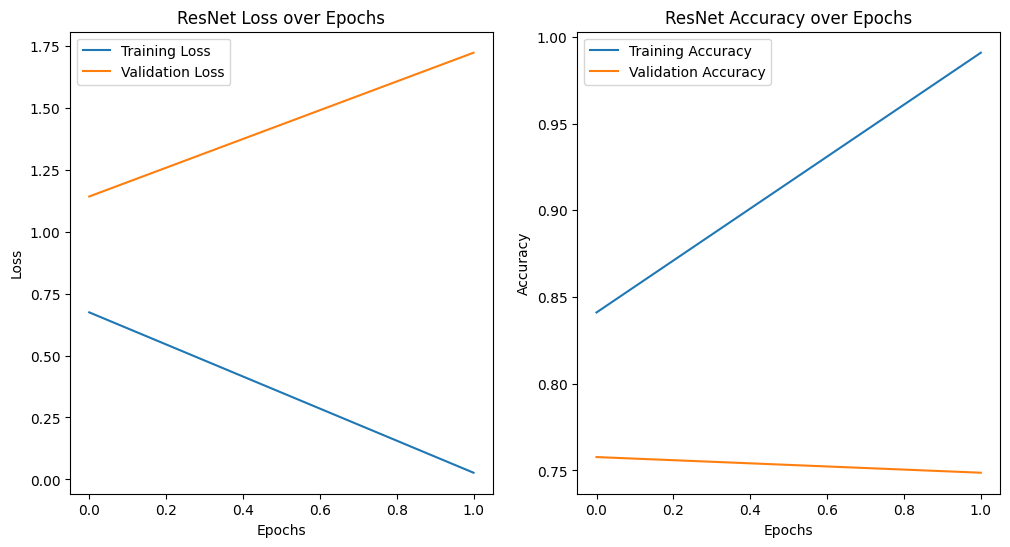

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Training MobileNet...
Memory usage (MB): [4661]
Epoch 1/5
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 120s 5ms/step - accuracy: 0.7706 - loss: 0.7202 - val_accuracy: 0.8163 - val_loss: 1.6860
Epoch 2/5
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 106s 5ms/step - accuracy: 0.9615 - loss: 0.1090 - val_accuracy: 0.7276 - val_loss: 1.6097
Epoch 3/5
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 106s 5ms/step - accuracy: 0.9777 - loss: 0.0665 - val_accuracy: 0.7696 - val_loss: 2.0365
Epoch 1/2
18917/18917 ━━━━━━━━━━━━━━━━━━━━ 296s 13ms/step - accuracy: 0.4382 - loss: 2.2306 - val_accuracy: 0.7302 - val_loss: 1.0722
Epoch 2/2
18917/18917 ━━━━━━━━━━━━━━━━━━━

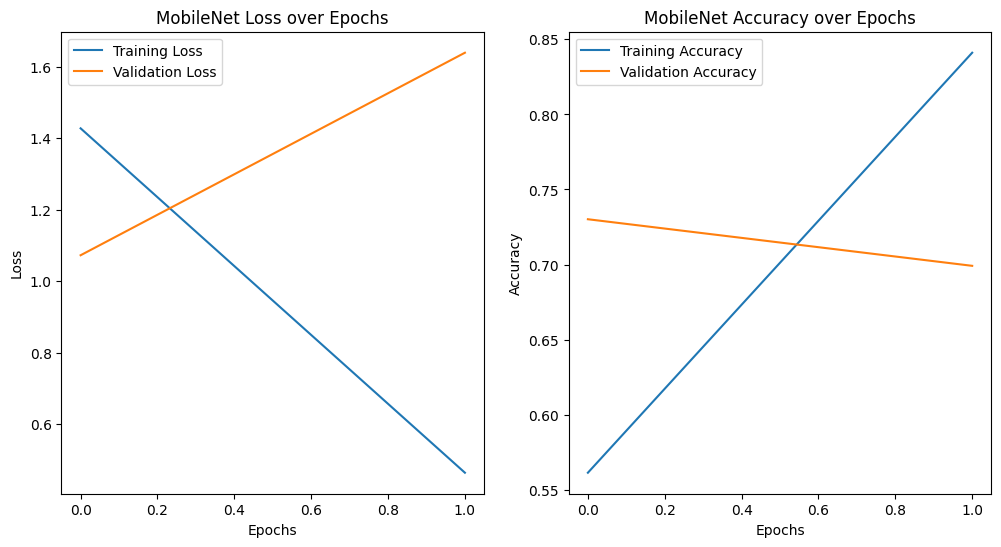

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [ ]:
# Step 5: Train and Evaluate Models

def measure_inference_time(model, test_dataset, num_batches=10):
    start_time = time.time()
    for i, (images, labels) in enumerate(test_dataset.take(num_batches)):
        _ = model.predict(images)
    inference_time = (time.time() - start_time) / num_batches
    return inference_time

# Measure memory usage during training
def measure_memory_usage_with_nvidia_smi():
    try:
        # Run nvidia-smi to get GPU memory usage
        result = subprocess.run(
            ["nvidia-smi", "--query-gpu=memory.used", "--format=csv,nounits,noheader"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        if result.returncode != 0:
            print(f"Error querying memory usage: {result.stderr}")
            return None

        # Parse memory usage (in MB)
        memory_usage = [int(x) for x in result.stdout.strip().split("\n")]
        print(f"Memory usage (MB): {memory_usage}")
        return max(memory_usage)  # Return peak memory usage
    except FileNotFoundError:
        print("nvidia-smi command not found.")
        return None

def plot_training_curves(history, model_name):
    plt.figure(figsize=(12, 6))

    # Loss 곡선
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 곡선
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

def train_and_evaluate_model(model_name, base_model, train_dataset, valid_dataset, test_dataset):
    tf.keras.backend.clear_session()  # Clear previous models
    if model_name != "CNN":
        model = build_transfer_learning_model(base_model)
    else:
        model = base_model

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    memory_usage = measure_memory_usage_with_nvidia_smi()

    # Early Stopping Callback
    from tensorflow.keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

    # Initial Training
    history = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=5,  # All models: Epoch=5
        class_weight=class_weight_dict,
        callbacks=[early_stopping]  # Early stopping to save time
    )

    # Fine-tuning for Transfer Learning models
    if memory_usage and memory_usage < 8000:  # 메모리 조건 검증
      base_model.trainable = True
      model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
      history = model.fit(
          train_dataset,
          validation_data=valid_dataset,
          epochs=2,  # Fine-tuning
          class_weight=class_weight_dict,
          callbacks=[early_stopping]
      )

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_dataset)

    # Confusion Matrix 및 Classification Report
    y_pred = model.predict(test_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)

    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    class_report = classification_report(y_true, y_pred_classes)

    print("Confusion Matrix:")
    print(conf_matrix)

    print("\nClassification Report:")
    print(class_report)

    # 학습 곡선 시각화
    plot_training_curves(history, model_name)

    inference_time = measure_inference_time(model, test_dataset)

    return history, training_time, test_accuracy, inference_time, memory_usage

results = []

for name, base_model in base_models.items():
    print(f"Training {name}...")
    history, training_time, test_accuracy, inference_time, memory_usage = train_and_evaluate_model(
        name, base_model, train_dataset, valid_dataset, test_dataset
    )
    results.append({
        "Model": name,
        "Training Time (s)": training_time,
        "Test Accuracy": test_accuracy,
        "Inference Time (s)": inference_time,
        "Memory Usage (MB)": memory_usage
    })

Performance Summary:
          Model  Training Time (s)  Test Accuracy  Inference Time (s)  \
0           CNN         751.945434       0.257324            0.230562   
1        VGGNet         751.945434       0.674268            0.152292   
2  InceptionNet         751.945434       0.486936            0.562607   
3        ResNet         751.945434       0.663975            0.419649   
4     MobileNet         751.945434       0.799208            0.342909   

   Memory Usage (MB)  
0               2599  
1               2601  
2               2603  
3               4657  
4               4661  


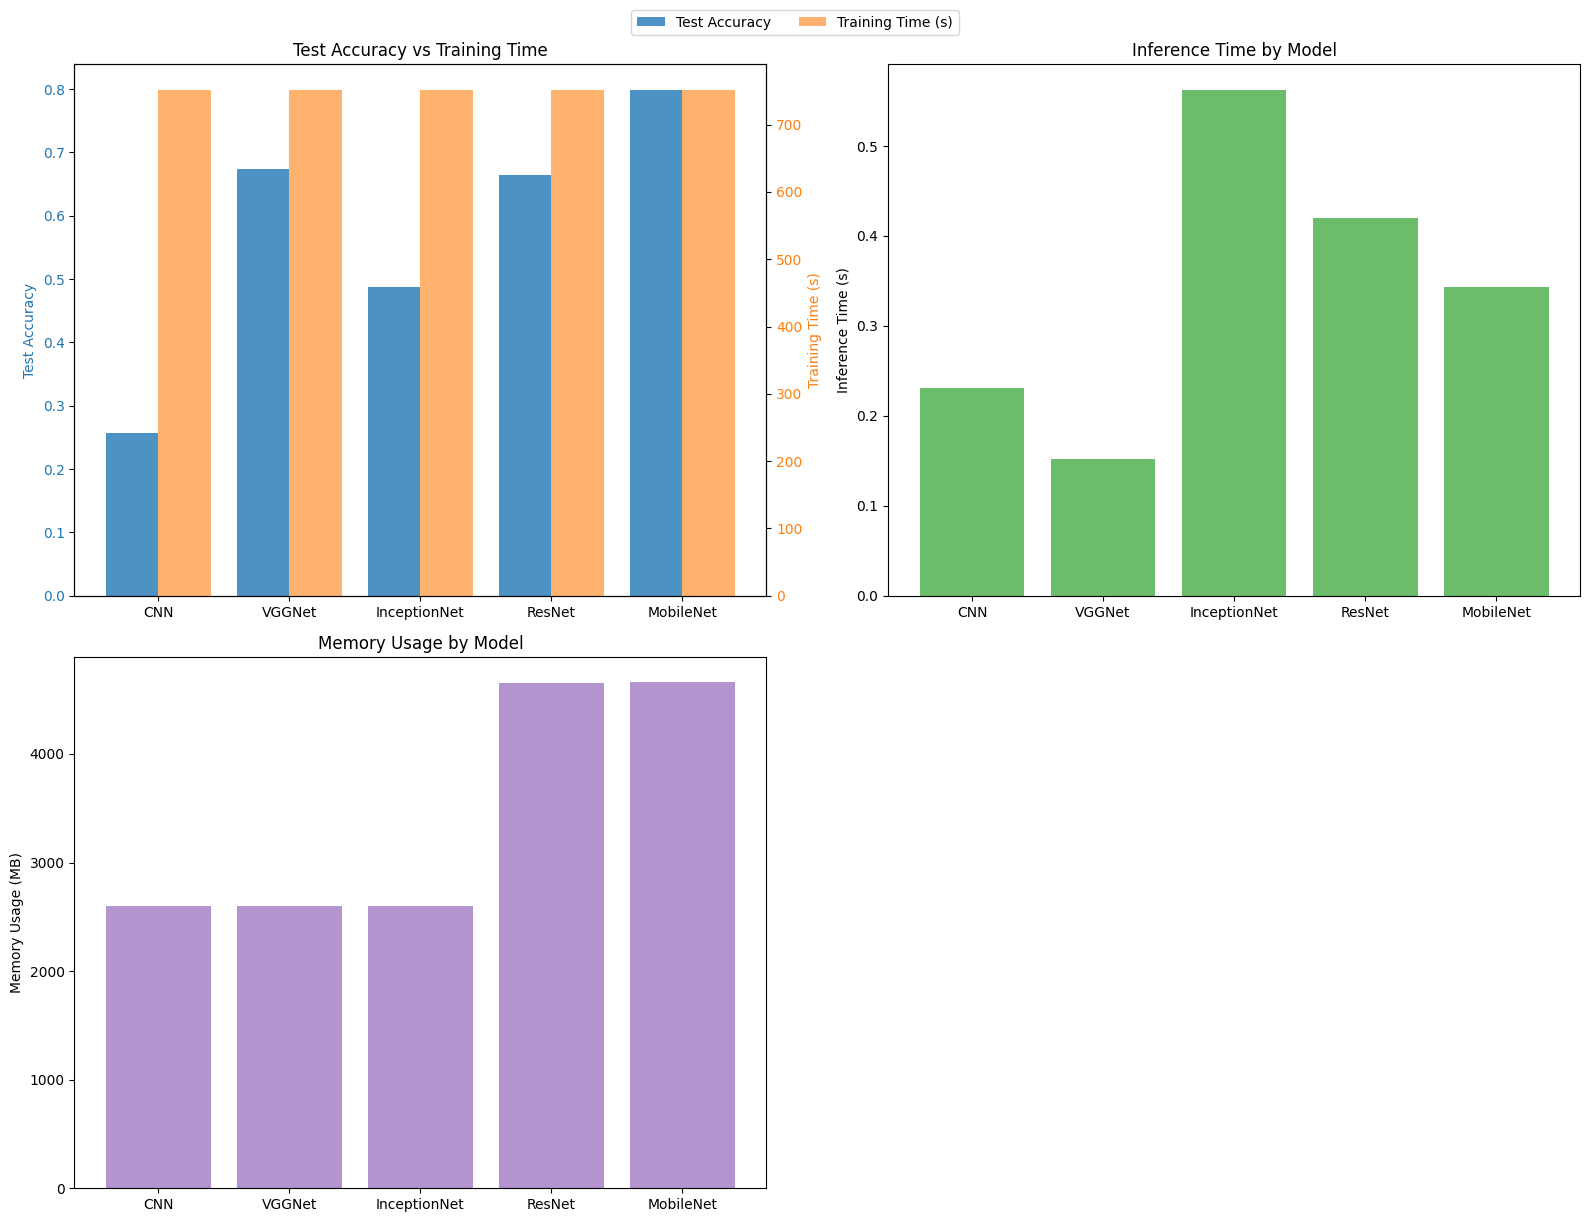

In [ ]:
# Step 6: Visualize Results
performance_df = pd.DataFrame(results)
print("Performance Summary:")
print(performance_df)

# Create a single figure for all plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # 2x2 grid of subplots

# Bar Plot for Test Accuracy and Training Time with Dual Y-Axis
ax1 = axes[0, 0]  # Top-left plot
ax2 = ax1.twinx()

x = np.arange(len(performance_df['Model']))

# Test Accuracy (Left Y-axis)
ax1.bar(x - 0.2, performance_df['Test Accuracy'], width=0.4, label='Test Accuracy', color='tab:blue', alpha=0.8)
ax1.set_ylabel('Test Accuracy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Training Time (Right Y-axis)
ax2.bar(x + 0.2, performance_df['Training Time (s)'], width=0.4, label='Training Time (s)', color='tab:orange', alpha=0.6)
ax2.set_ylabel('Training Time (s)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Title and X-axis
ax1.set_title('Test Accuracy vs Training Time')
ax1.set_xticks(x)
ax1.set_xticklabels(performance_df['Model'])
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.02), ncol=2)

# Inference Time Bar Plot
axes[0, 1].bar(performance_df['Model'], performance_df['Inference Time (s)'], color='tab:green', alpha=0.7)
axes[0, 1].set_title('Inference Time by Model')
axes[0, 1].set_ylabel('Inference Time (s)')

# Memory Usage Bar Plot
axes[1, 0].bar(performance_df['Model'], performance_df['Memory Usage (MB)'], color='tab:purple', alpha=0.7)
axes[1, 0].set_title('Memory Usage by Model')
axes[1, 0].set_ylabel('Memory Usage (MB)')

# Hide empty subplot (Bottom-right)
axes[1, 1].axis('off')

# Adjust layout to fit everything
plt.tight_layout()
plt.show()